# Machine Learning Pipeline - Model Training

In this notebook, we use the transformed datasets and the selected variables that we saved in the previous notebooks.

## Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environments, for each step that includes some element of randomness, it is extremely important that we set the seed.

In [1]:
import numpy as np
from scipy.special import inv_boxcox
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
pd.pandas.set_option('display.max_columns', None)

In [2]:
# load the train and test set with the engineered variables

X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')

X_train.head()

,longitude,latitude,housing_median_age,total_rooms,population,median_income,ocean_proximity,income_bracket,rooms_per_household,bedrooms_per_household,population_per_household,median_income_per_household
0,1.990148,-0.831603,-0.584061,-0.822229,-0.693618,-0.181254,-1.253415,-0.481839,0.604762,2.352336,0.083696,-0.022035
1,0.958314,-1.031433,-1.063452,1.993611,1.469553,1.157683,-0.300872,2.012706,0.604762,-0.112234,0.083696,-0.022035
2,0.928406,-0.729364,1.892792,-1.633859,1.258138,-1.305856,-1.253415,-0.481839,-0.925870,-0.112234,0.083696,-0.022035
3,-0.796302,1.403711,-1.862437,1.910722,1.215999,1.251134,-1.253415,2.012706,0.604762,-0.112234,0.083696,-0.022035
4,-1.284803,0.962225,1.892792,0.418302,0.146383,0.267953,1.604215,-0.481839,-0.065493,-0.112234,0.083696,-0.022035


In [3]:
# load the target (remember that the target is Yeo-Johnson transformed)
y_train = pd.read_csv('ytrain.csv')
y_test = pd.read_csv('ytest.csv')

y_train.head()

,median_house_value
0,11.180246
1,12.385473
2,12.266697
3,12.401639
4,12.119970


In [4]:
# load the pre-selected features
# ==============================

features = pd.read_csv('selected_features.csv')
features = features['0'].to_list() 

# display final feature set
features

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'population',
 'median_income',
 'ocean_proximity',
 'income_bracket',
 'rooms_per_household',
 'bedrooms_per_household',
 'population_per_household',
 'median_income_per_household']

In [5]:
# reduce the train and test set to the selected features

X_train = X_train[features]
X_test = X_test[features]

## Model Selection Pipeline

Here we will compare 3 Regression models and select the best model with it's corresponding hyperparameters

In [6]:
# set up the models
# remember to set the random_state / seed

lasso = Lasso(random_state=0)
rfr = RandomForestRegressor(random_state=0)
gbr = GradientBoostingRegressor(random_state=0)

In [7]:
pipe = Pipeline([('regressor', lasso)])

In [8]:
# Create param dictionary for lasso
lasso_params = {}
lasso_params['regressor__alpha'] = [0.0005, 0.001, 0.0015, 0.002]
lasso_params['regressor__fit_intercept'] = [True, False]
lasso_params['regressor__max_iter'] = [750, 1000, 1250]
lasso_params['regressor'] = [lasso]

# Create param dictionary for random forest
rfr_params = {}
rfr_params['regressor__n_estimators'] = [100, 150, 200, 300]
rfr_params['regressor__min_samples_leaf'] = [2, 3]
rfr_params['regressor__n_jobs'] = [1, 2]
rfr_params['regressor'] = [rfr]

# Create param dictionary for gradient boosting
gbr_params = {}
gbr_params['regressor__learning_rate'] = [0.1, 0.2, 0.3]
gbr_params['regressor__n_estimators'] = [100, 150, 200, 300]
gbr_params['regressor__min_samples_leaf'] = [2, 3]
gbr_params['regressor'] = [gbr]

In [9]:
params = [lasso_params, rfr_params, gbr_params]

In [10]:
grid = GridSearchCV(pipe, params, verbose=3, error_score='raise', scoring='neg_mean_squared_error')
grid.fit(X_train, y_train.values.ravel())
grid.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END regressor=Lasso(random_state=0), regressor__alpha=0.0005, regressor__fit_intercept=True, regressor__max_iter=750;, score=-0.102 total time=   0.0s
[CV 2/5] END regressor=Lasso(random_state=0), regressor__alpha=0.0005, regressor__fit_intercept=True, regressor__max_iter=750;, score=-0.089 total time=   0.0s
[CV 3/5] END regressor=Lasso(random_state=0), regressor__alpha=0.0005, regressor__fit_intercept=True, regressor__max_iter=750;, score=-0.096 total time=   0.0s
[CV 4/5] END regressor=Lasso(random_state=0), regressor__alpha=0.0005, regressor__fit_intercept=True, regressor__max_iter=750;, score=-0.093 total time=   0.0s
[CV 5/5] END regressor=Lasso(random_state=0), regressor__alpha=0.0005, regressor__fit_intercept=True, regressor__max_iter=750;, score=-0.101 total time=   0.0s
[CV 1/5] END regressor=Lasso(random_state=0), regressor__alpha=0.0005, regressor__fit_intercept=True, regressor__max_iter=1000;, score=-0.

{'regressor': GradientBoostingRegressor(learning_rate=0.3, min_samples_leaf=3,
                           n_estimators=300, random_state=0),
 'regressor__learning_rate': 0.3,
 'regressor__min_samples_leaf': 3,
 'regressor__n_estimators': 300}

### Selected model: `GradientBoostingRegressor()`

In [11]:
# set up the model
# remember to set the random_state / seed

model = GradientBoostingRegressor(min_samples_leaf=3, n_estimators=300, learning_rate=0.3,
                       random_state=0)

# train the model

model.fit(X_train, y_train.values.ravel())

GradientBoostingRegressor(learning_rate=0.3, min_samples_leaf=3,
                          n_estimators=300, random_state=0)

# Evaluate the model:

---

Remember that we transformed the output (median_house_value) in our feature engineering notebook (step 2). In order to get the true performance of the Regressor, we need to transform both the target and the predictions back to the original house prices values.

In [12]:
# We will evaluate performance using the mean squared error and
# the root of the mean squared error and r2

# make predictions for train set
pred = model.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = model.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 1360281686
train rmse: 36881
train r2: 0.8554074478088672

test mse: 1963635269
test rmse: 44312
test r2: 0.7927059118332437

Average house price:  172799


Text(0.5, 1.0, 'Evaluation of Random Forest Predictions')

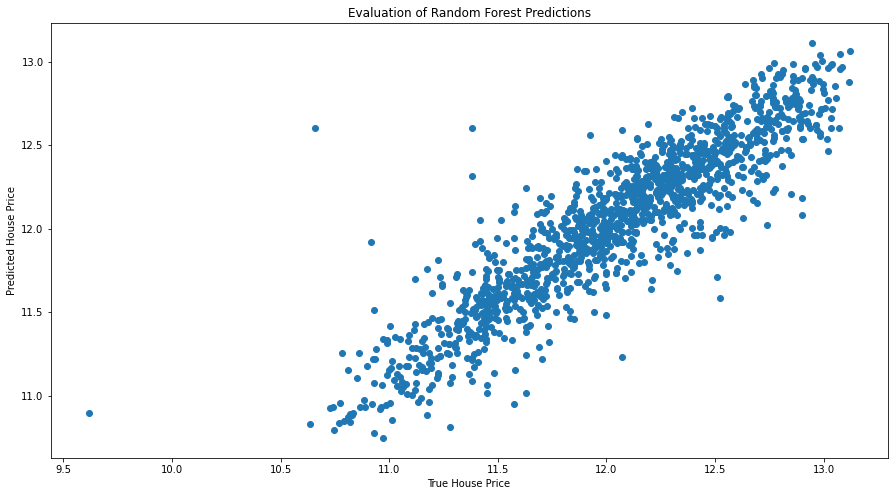

In [13]:
# let's evaluate our predictions respect to the real sale price
plt.figure(figsize=(15, 8))
plt.scatter(y_test, model.predict(X_test))
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Random Forest Predictions')

Our model is doing a pretty good job at estimating house prices

In [14]:
y_test.reset_index(drop=True)

,median_house_value
0,12.388394
1,11.528799
2,11.289782
3,12.100712
4,12.851342
...,...
1369,11.943408
1370,11.218554
1371,11.848683
1372,12.618513


In [15]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(model.predict(X_test))

preds

0       12.176156
1       11.345799
2       11.185744
3       11.980229
4       12.438858
          ...    
1369    11.701698
1370    11.228321
1371    12.140263
1372    12.506331
1373    11.912040
Length: 1374, dtype: float64

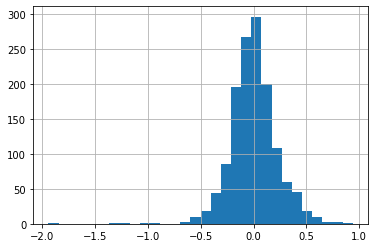

In [16]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

errors = y_test['median_house_value'] - preds
errors.hist(bins=30)
plt.show()

The error distribution shows a very nice gaussian trend. This also suggests great model performance in making predictions

In [17]:
# Finally, just for fun, let's look at the feature importance

feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances.reset_index()
feature_importances

,index,importance
0,median_income,0.367301
1,ocean_proximity,0.343559
2,longitude,0.094090
3,latitude,0.091910
4,population,0.031764
5,total_rooms,0.030765
6,housing_median_age,0.021113
7,rooms_per_household,0.014136
8,population_per_household,0.004718
9,bedrooms_per_household,0.000574


<AxesSubplot:xlabel='importance', ylabel='index'>

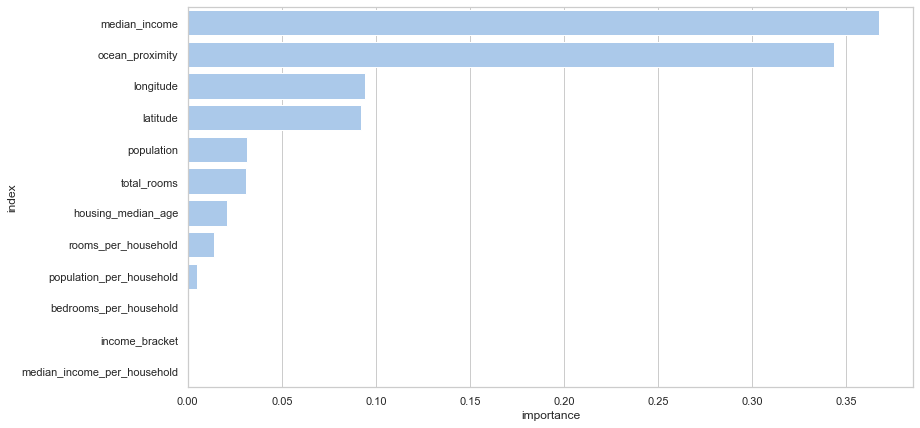

In [18]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))

# Plot the Feature Importance
sns.set_color_codes("pastel")
sns.barplot(x="importance", y='index', data=feature_importances,
            label="Total", color="b")

<AxesSubplot:xlabel='importance', ylabel='index'>

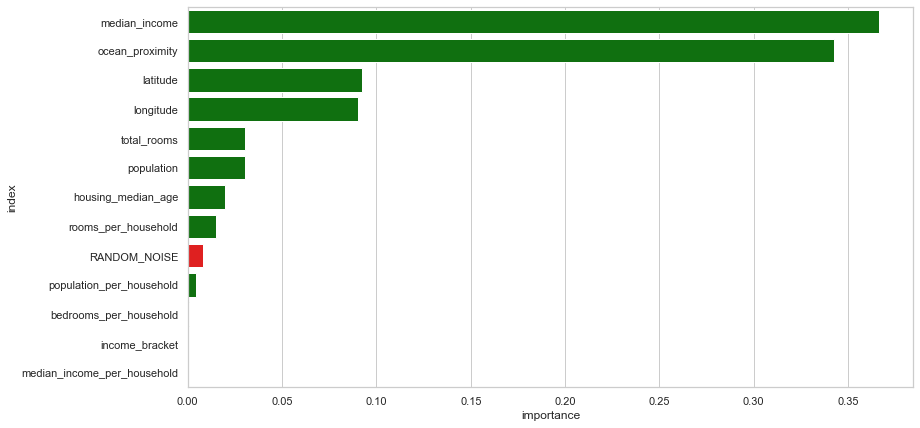

In [22]:
# Apply Random Noise to data set
X_train_rnoise = pd.DataFrame(X_train)
X_train_rnoise['RANDOM_NOISE'] = np.random.normal(0, 1, X_train_rnoise.shape[0])

# Fit Random Forest to DataSet
gb_random = GradientBoostingRegressor(min_samples_leaf=3, n_estimators=300, learning_rate=0.3,
                       random_state=0)
gb_random = gb_random.fit(X_train_rnoise, y_train.values.ravel())

# Get Feature Importances
feature_importances_random = pd.DataFrame(gb_random.feature_importances_, index = X_train_rnoise.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances_random = feature_importances_random.reset_index()

# Create Seaborn PLot
sns.set(style="whitegrid")
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(13, 7))


clrs = ['red' if (x == 8) else 'green' for x in feature_importances_random.index.values ]

# Plot the Feature Importance
sns.barplot(x="importance", y='index', data=feature_importances_random,
            label="Total",  palette=clrs)

## Save the Model

In [24]:
# we are happy to our model, so we save it to be able
# to score new data

joblib.dump(model, 'gradient_boosting.joblib') 

['gradient_boosting.joblib']